In [280]:
import numpy as np
import pandas as pd
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MultilabelClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [165]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

#    .config( \
#    "spark.archives",  \
#    "pyspark_venv.tar.gz#environment") \

# Read in full sparkify dataset
feature_data = "./features.json"

df = spark.read.json(feature_data)
df.persist()
df.createOrReplaceTempView('df')
df.head()

Row(adverts_per_song=0.07240704500978473, adverts_per_song_free=0.07240704500978473, adverts_per_song_paid=0.0, artist_diversity=0.7504892367906066, churn=1, downgrade_visits=3, errors_per_activity=0.002277904328018223, friends_added=14, gender='M', help_visits_per_activity=0.006074411541381929, home_visits_per_activity=0.033409263477600606, location='Findlay, OH', mobile=0.0, pc=1.0, skip_ahead_per_song=0.015655577299412915, song_diversity=0.9275929549902152, songs_in_playlist=25, songs_per_artist=1.2359843546284224, submitted_downgrades=1, tablet=0.0, thumbs_down_per_song=0.03228962818003914, thumbs_up_per_song=0.05185909980430528, upgrade_visits=9, userId='1000280')

In [166]:
df.printSchema()

root
 |-- adverts_per_song: double (nullable = true)
 |-- adverts_per_song_free: double (nullable = true)
 |-- adverts_per_song_paid: double (nullable = true)
 |-- artist_diversity: double (nullable = true)
 |-- churn: long (nullable = true)
 |-- downgrade_visits: long (nullable = true)
 |-- errors_per_activity: double (nullable = true)
 |-- friends_added: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- help_visits_per_activity: double (nullable = true)
 |-- home_visits_per_activity: double (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: double (nullable = true)
 |-- pc: double (nullable = true)
 |-- skip_ahead_per_song: double (nullable = true)
 |-- song_diversity: double (nullable = true)
 |-- songs_in_playlist: long (nullable = true)
 |-- songs_per_artist: double (nullable = true)
 |-- submitted_downgrades: long (nullable = true)
 |-- tablet: double (nullable = true)
 |-- thumbs_down_per_song: double (nullable = true)
 |-- thumbs_up_per_song:

In [246]:
(trainingData, testData) = df.randomSplit([0.75, 0.25])

## DataFrame preparation and scaling

In [250]:
# common functions
def get_metrics(prediction):
    predictionAndLabels = prediction.withColumn("churnD",col("churn").cast("Double")).select(['prediction', 'churnD']).rdd
    return MulticlassMetrics(predictionAndLabels)

def display_metrics(metrics):
    display(metrics.confusionMatrix().toArray())
    print('precision: ', metrics.precision(1.0))
    print('   recall: ', metrics.recall(1.0))
    print(' accuracy: ', metrics.accuracy)
    print('       f1: ', metrics.fMeasure(1.0, 1.0)) # label, beta
    ax = sns.heatmap(metrics.confusionMatrix().toArray(), annot=True, fmt='g')
    ax.set(xlabel='Predicted Churn', ylabel='True Churn', title='Confusion Matrix')

In [247]:
def build_pipeline(classifier):
    stages = [StringIndexer(inputCol=column, outputCol=column+"IDX") for column in ['gender', 'location']]
    onehotencoder = OneHotEncoder(inputCols=["locationIDX"], outputCols=["locationVec"])
    stages.append(onehotencoder)

    assembler = VectorAssembler(
        inputCols=["adverts_per_song", "adverts_per_song_free", "adverts_per_song_paid", "artist_diversity", "downgrade_visits", "errors_per_activity", "friends_added",  
                   "help_visits_per_activity", "home_visits_per_activity", "mobile", "pc", "skip_ahead_per_song", "song_diversity", "songs_in_playlist", "songs_per_artist", "submitted_downgrades", 
                   "tablet", "thumbs_down_per_song", "thumbs_up_per_song", "upgrade_visits", "genderIDX"],
        outputCol="features")

    stages.append(assembler)

    scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
    stages.append(scaler)
    stages.append(classifier)

    return Pipeline(stages=stages)

## Random Forest Classifier

In [276]:
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(rf)

In [277]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .addGrid(rf.numTrees, [5, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricLabel=1.0, metricName='fMeasureByLabel'),
                          numFolds=5)  

rf_model = crossval.fit(trainingData)

array([[12820.,   140.],
       [ 2630.,  1095.]])

precision:  0.8866396761133604
   recall:  0.29395973154362415
 accuracy:  0.8339826191189691
       f1:  0.44153225806451607


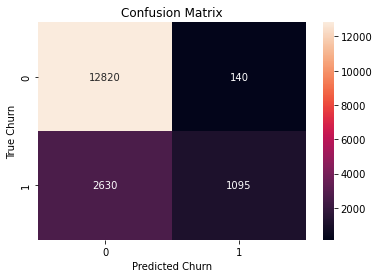

In [278]:
trainPred = rf_model.transform(trainingData)
trainMetrics = get_metrics(trainPred)
display_metrics(trainMetrics)

array([[4134.,  165.],
       [1048.,  229.]])

precision:  0.5812182741116751
   recall:  0.1793265465935787
 accuracy:  0.7824605451936872
       f1:  0.27408737283064033


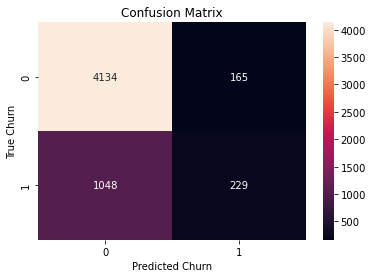

In [279]:
testPred = rf_model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testMetrics)

## Gradient Boosted Tree

In [265]:
gbt = GBTClassifier(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(gbt)

In [266]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 10]) \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricLabel=1.0, metricName='fMeasureByLabel'),
                          numFolds=5)  

model = crossval.fit(trainingData)

array([[12558.,   402.],
       [ 2690.,  1035.]])

precision:  0.7202505219206681
   recall:  0.2778523489932886
 accuracy:  0.8146838477674558
       f1:  0.4010073614877954


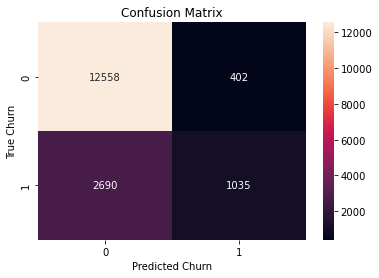

In [267]:
trainPred = model.transform(trainingData)
trainMetrics = get_metrics(trainPred)
display_metrics(trainMetrics)

array([[4109.,  190.],
       [1017.,  260.]])

precision:  0.5777777777777777
   recall:  0.20360219263899765
 accuracy:  0.7835365853658537
       f1:  0.30110017371163866


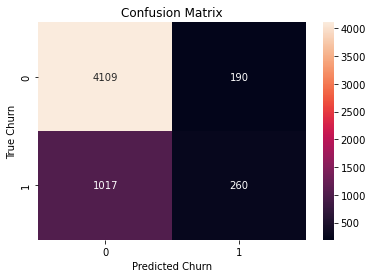

In [268]:
testPred = model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testMetrics)

## Linear Support Vector Machine

In [281]:
svc = LinearSVC(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(svc)


In [287]:
paramGrid = ParamGridBuilder() \
    .addGrid(svc.maxIter, [5, 10, 20, 50]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricLabel=1.0, metricName='fMeasureByLabel'),
                          numFolds=5)  

svc_model = crossval.fit(trainingData)

array([[1.295e+04, 1.000e+01],
       [3.696e+03, 2.900e+01]])

precision:  0.7435897435897436
   recall:  0.007785234899328859
 accuracy:  0.777884327240036
       f1:  0.015409139213602551


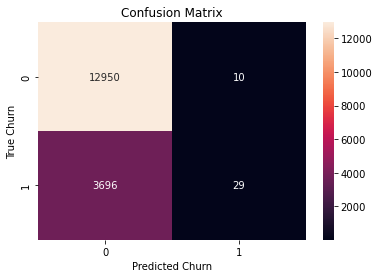

In [288]:
trainPred = svc_model.transform(trainingData)
trainMetrics = get_metrics(trainPred)
display_metrics(trainMetrics)

array([[4.296e+03, 3.000e+00],
       [1.274e+03, 3.000e+00]])

precision:  0.5
   recall:  0.0023492560689115116
 accuracy:  0.7709827833572453
       f1:  0.004676539360872954


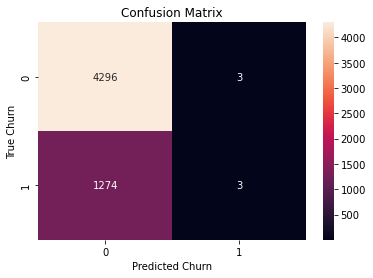

In [289]:
testPred = svc_model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testMetrics)

## Baseline informed random guess

In [253]:
spark.sql('''
select sum(churn) / count(*) from df
''').show()

testPred.createOrReplaceTempView('testPred')
spark.sql('''
select  count(*) from testPred
''').show()

+-----------------------+
|(sum(churn) / count(1))|
+-----------------------+
|    0.22469790216072952|
+-----------------------+

+--------+
|count(1)|
+--------+
|    5576|
+--------+



In [290]:
def get_random_prediction():
    p = 0.22469790216072952 # overall likelyhood of churn in dataset
    random_pred = np.random.choice([0,1], size=(5576), p=[1-p, p])
    randomPred = testPred.select('churn').toPandas()
    randomPred['prediction'] = random_pred
    return spark.createDataFrame(randomPred.astype('double'))

In [292]:
get_random_prediction().show(15)

+-----+----------+
|churn|prediction|
+-----+----------+
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 15 rows



/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([[3322.,  977.],
       [ 991.,  286.]])

precision:  0.22644497228820268
   recall:  0.22396241190289742
 accuracy:  0.6470588235294118
       f1:  0.2251968503937008


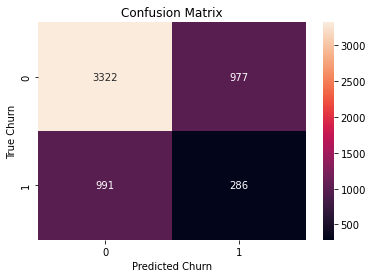

In [293]:
display_metrics(get_metrics(get_random_prediction()))

In [300]:
evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricLabel=1.0, metricName='fMeasureByLabel')
f1_collected = []

for _ in range(1000):
    f1_collected.append(evaluator.evaluate(get_random_prediction()))
    

<AxesSubplot:ylabel='Count'>

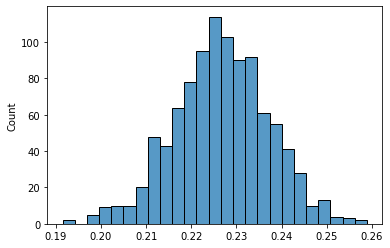

In [301]:
sns.histplot(f1_collected)